# Estimating ancestry

If samples in the reference haplotype panel are labeled with a population origin, MendelImpute can also be used for:

+ Estimate admixed proportions
+ Chromosome painting

We use the [1000 genomes chromosome 22](http://bochet.gcc.biostat.washington.edu/beagle/1000_Genomes_phase3_v5a/b37.vcf/) as illustration. Example code to generate plots are presented. 

In [1]:
# first load all necessary packages
using MendelImpute
using VCFTools
using GeneticVariation
using Random
using DataFrames
using Plots
using JLSO

## Data preparation

### Step 0. Filter chromosome data 

The original chromosome data are filtered into target and reference panels. Follow [detailed example](https://biona001.github.io/MendelImpute/dev/man/Phasing+and+Imputation/#Detailed-Example) in Phasing and Imputation to obtain the same data.

### Step 1. Get population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample via the command below (note `wget` will probably not work on non-Mac OS). Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

For easier processing, copy the country of origin data into a folder called `data`. It should look contain these subfolders (where each population code contains the sample IDs that belong to the population):

In [3]:
;ls data

ACB
ASW
BEB
CDX
CEU
CHB
CHS
CLM
ESN
FIN
GBR
GIH
GWD
IBS
ITU
JPT
KHV
LWK
MSL
MXL
PEL
PJL
PUR
STU
TSI
YRI


### Step 2. Process each sample's population origin

The goal here is to create a `Dict{key, value}` where each key is a sample ID and the value is the population code. This will be used for both the [paint](https://biona001.github.io/MendelImpute/dev/man/api/#MendelImpute.paint) and [composition](https://biona001.github.io/MendelImpute/dev/man/api/#MendelImpute.composition) function.

Here the population origin for different samples are encoded in weird subfolder directory way. We process them into the desired dictionary structure.

In [4]:
df = DataFrame(sample = String[], population = String[])
refID_to_population = Dict{String, String}()
for population in readdir("data/")
    population == ".DS_Store" && continue # skip auxiliary files
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue # skip auxiliary files
        push!(df, (sample, population))
        refID_to_population[sample] = population
    end
end
refID_to_population

Dict{String,String} with 2709 entries:
  "HG01791" => "GBR"
  "HG02736" => "PJL"
  "HG00182" => "FIN"
  "HG03914" => "BEB"
  "HG00149" => "GBR"
  "NA12156" => "CEU"
  "HG02642" => "GWD"
  "HG02851" => "GWD"
  "NA19835" => "ASW"
  "NA19019" => "LWK"
  "HG01131" => "CLM"
  "HG03725" => "ITU"
  "HG03578" => "MSL"
  "NA18550" => "CHB"
  "HG02401" => "CDX"
  "HG01350" => "CLM"
  "HG03973" => "ITU"
  "NA07000" => "CEU"
  "HG01709" => "IBS"
  "HG01395" => "PUR"
  "HG02388" => "CDX"
  "HG01980" => "PEL"
  "HG01979" => "PEL"
  "HG01122" => "CLM"
  "HG03869" => "ITU"
  ⋮         => ⋮

### Step 3. Compute phase information using MendelImpute

This is equivalent to running a typical imputation. Please ensure that:
+ The output file name ends with `.jlso` (save output to ultra-compressed format)
+ `impute = true` (so the output contains the entire chromosome)

Note data used here is prepared in [Detailed Example](https://biona001.github.io/MendelImpute/dev/man/Phasing+and+Imputation/#Detailed-Example).

In [6]:
# compute each person's phase information
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
reffile = "ref.chr22.maxd1000.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile);

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:20


Total windows = 1634, averaging ~ 508 unique haplotypes per window.

Timings: 
    Data import                     = 10.2246 seconds
        import target data             = 2.21667 seconds
        import compressed haplotypes   = 8.00795 seconds
    Computing haplotype pair        = 20.127 seconds
        BLAS3 mul! to get M and N      = 1.01193 seconds per thread
        haplopair search               = 18.724 seconds per thread
        initializing missing           = 0.0977775 seconds per thread
        allocating and viewing         = 0.273912 seconds per thread
        index conversion               = 0.00868801 seconds per thread
    Phasing by win-win intersection = 3.82254 seconds
        Window-by-window intersection  = 0.559845 seconds per thread
        Breakpoint search              = 3.23837 seconds per thread
        Recording result               = 0.00971604 seconds per thread
    Imputation                     = 0.141786 seconds
        Imputing missing               

## Estimate admixture proportions

The [composition](https://biona001.github.io/MendelImpute/dev/man/api/#MendelImpute.composition) will compute a list of percentages where `composition[i]` equals the sample's ancestry (in %) from `populations[i]`. Thus we simply have to plot the result. This illustration depends on **data preparation** above. 

### Step 1: import necessary data

In [7]:
# First import compressed reference panel
reffile = "ref.chr22.maxd1000.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# also need target sample's ancestry
tgtfile = "target.chr22.typedOnly.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];

In [8]:
# here is our sample population (sample 1 is GBR, 4 is CHS, 84 is LWK...etc)
sample_population

100-element Array{String,1}:
 "GBR"
 "FIN"
 "CHS"
 "CHS"
 "CDX"
 "CDX"
 "PUR"
 "PUR"
 "PUR"
 "PUR"
 "GBR"
 "CLM"
 "IBS"
 ⋮
 "MXL"
 "ASW"
 "ASW"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "TSI"
 "GIH"
 "GIH"

### Step 2: call `composition` function

The [composition](https://biona001.github.io/MendelImpute/dev/man/api/#MendelImpute.composition) will compute a list of percentages where `composition[i]` equals the sample's ancestry (in %) from `populations[i]`. We are finally using the imputation result stored in `ph`.

In [9]:
populations = MendelImpute.unique_populations(refID_to_population)
@time sample1_comp = composition(ph[1], panelID, refID_to_population) # origin GBR
@time sample4_comp = composition(ph[4], panelID, refID_to_population) # origin CHS
@time sample84_comp = composition(ph[84], panelID, refID_to_population) # origin LWK

  0.004665 seconds (28 allocations: 2.719 KiB)
  0.000369 seconds (8 allocations: 1.250 KiB)
  0.000383 seconds (8 allocations: 1.250 KiB)


26-element Array{Float64,1}:
 0.03159153536944775
 0.004281873442329377
 0.0183269450383178
 0.0025138200248509064
 0.0014987155576730166
 0.11780598576459632
 0.0104802353893189
 0.21297801484829695
 0.0338623527918964
 0.004151394212468068
 0.07204967308369105
 0.0002681408026507634
 0.004550014244980141
 0.013386690160908423
 0.06359485840010917
 0.006903428611102466
 0.0006188785489751994
 0.1910251836884204
 0.01634940661876842
 0.06281796830671477
 0.0004357288043074905
 0.003690527207912069
 0.11661611095283356
 0.006875896296544575
 0.0028884989142691606
 0.0004381229186168723

Note the first run is slower because Julia has to compile the code. 

### Step 3: Plot the percentages

We computed the population percentages for sample 1, 4, and 84. Here `sample1_comp[i]` equals the sample's estimated ancestry (in %) from `populations[i]`. Thus we simply have to create a bar plot for each:

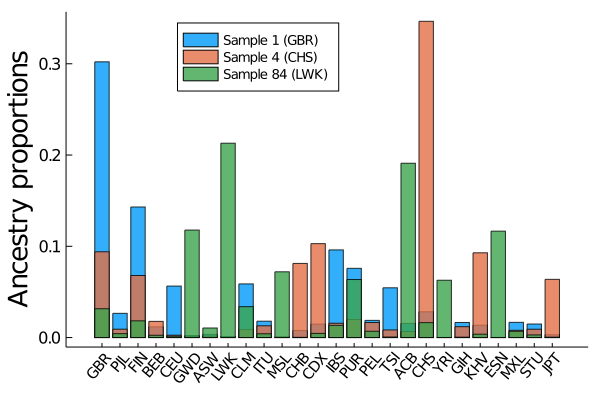

In [10]:
barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=50, grid=false, 
    ylabel = "Ancestry proportions", label="Sample 1 (GBR)", alpha=0.8, legend=:top,
    xtickfont=font(10), ytickfont=font(11), legendfont=font(9), yguidefontsize=18)
bar!(barplot, sample4_comp, label="Sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample84_comp, label="Sample 84 (LWK)", alpha=0.8)

## Chromosome painting

The main function is the [paint](https://biona001.github.io/MendelImpute/dev/man/api/#MendelImpute.paint) function. For an imputed sample, it will convert **each haplotype segment** into a percentage indicating the segment's length in the chromosome. Then the list can be used for easy plotting. 

**Note:** this illustration depends on **data preparation** above. 

### Step 1: Choose your colors

In this example, colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

Of course, Julia lets you plot your favoriate colors. We pick our colors here: https://mdigi.tools/color-shades/#008000.

In [11]:
# generated here: https://mdigi.tools/color-shades/#008000
# Blue ≈ European/American, Red ≈ Asian, Green ≈ Africa
goodcolors = [colorant"#c8c8ff", colorant"#ffeaea", colorant"#ffbfbf", colorant"#a4a4ff",
    colorant"#8080ff", colorant"#e3ffe3", colorant"#aaffaa", colorant"#71ff71", 
    colorant"#5b5bff", colorant"#ff9595", colorant"#39ff39", colorant"#ff6a6a",
    colorant"#ff4040", colorant"#3737ff", colorant"#1212ff", colorant"#0000c8", 
    colorant"#0000a4", colorant"#00ff00", colorant"#ff1515", colorant"#00c600", 
    colorant"#ea0000", colorant"#bf0000", colorant"#008e00", colorant"#00005b",
    colorant"#950000", colorant"#6a0000"]

### Step 2: Run `paint` funcion

This function convert the imputed haplotype segments into a list of percentages (one list for each strand). This is simply a post-processing routine so that data can be used for easy plotting later.

In [12]:
populations = unique_populations(refID_to_population)
@time sample1_s1_comp, sample1_s2_comp = paint(ph[1], panelID, refID_to_population)
@time sample4_s1_comp, sample4_s2_comp = paint(ph[4], panelID, refID_to_population)
@time sample84_s1_comp, sample84_s2_comp = paint(ph[84], panelID, refID_to_population);

  0.000323 seconds (12 allocations: 19.125 KiB)
  0.000310 seconds (12 allocations: 20.375 KiB)
  0.000307 seconds (12 allocations: 22.875 KiB)


### Step 3: Generate plots for painted chromosomes

We found the [StatsPlots.jl](https://github.com/JuliaPlots/StatsPlots.jl) package to be more useful for this purpose, although the code below still did the plotting in a very roundabout way. 

In [13]:
# assign a color to each haplotype segment
sample1_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s1_comp[2]]
sample1_s1_colors = reshape(sample1_s1_colors, 1, length(sample1_s1_colors))

sample1_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s2_comp[2]]
sample1_s2_colors = reshape(sample1_s2_colors, 1, length(sample1_s2_colors))

sample4_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s1_comp[2]]
sample4_s1_colors = reshape(sample4_s1_colors, 1, length(sample4_s1_colors))

sample4_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample4_s2_comp[2]]
sample4_s2_colors = reshape(sample4_s2_colors, 1, length(sample4_s2_colors))

sample84_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample84_s1_comp[2]]
sample84_s1_colors = reshape(sample84_s1_colors, 1, length(sample84_s1_colors))

sample84_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample84_s2_comp[2]]
sample84_s2_colors = reshape(sample84_s2_colors, 1, length(sample84_s2_colors));

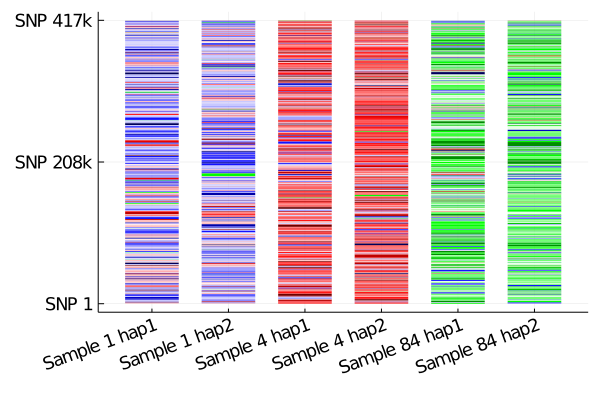

In [14]:
using StatsPlots, FixedPointNumbers

# some tedious and roundabout routine for making a bad groupedplot
sample1_s1l = length(sample1_s1_comp[1])
sample1_s2l = length(sample1_s2_comp[1])
sample4_s1l = length(sample4_s1_comp[1])
sample4_s2l = length(sample4_s2_comp[1])
sample84_s1l = length(sample84_s1_comp[1])
sample84_s2l = length(sample84_s2_comp[1])
maxlen = max(sample1_s1l, sample1_s2l, sample4_s1l, sample4_s2l, sample84_s1l, sample84_s2l)

mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_comp[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_comp[1])
copyto!(@view(mydata[3, 1:sample4_s1l]), sample4_s1_comp[1])
copyto!(@view(mydata[4, 1:sample4_s2l]), sample4_s2_comp[1])
copyto!(@view(mydata[5, 1:sample84_s1l]), sample84_s1_comp[1])
copyto!(@view(mydata[6, 1:sample84_s2l]), sample84_s2_comp[1])

mycolors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(mycolors[1, 1:sample1_s1l]), sample1_s1_colors)
copyto!(@view(mycolors[2, 1:sample1_s2l]), sample1_s2_colors)
copyto!(@view(mycolors[3, 1:sample4_s1l]), sample4_s1_colors)
copyto!(@view(mycolors[4, 1:sample4_s2l]), sample4_s2_colors)
copyto!(@view(mycolors[5, 1:sample84_s1l]), sample84_s1_colors)
copyto!(@view(mycolors[6, 1:sample84_s2l]), sample84_s2_colors)

# axis labels
xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 4 hap1", "Sample 4 hap2", "Sample 84 hap1", "Sample 84 hap2"]
ynames = ["SNP 1", "SNP 208k", "SNP 417k"]

# final plot
chrom_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=mycolors, xticks=(1:1:6, xnames), yticks=(0:0.5:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20)

For more details, please refer to our paper, or file an issue on GitHub. 